In [1]:
! nvidia-smi

Tue Jul 28 11:49:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36       Driver Version: 450.36       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:17:00.0 Off |                  N/A |
| 42%   54C    P0    37W / 250W |      0MiB / 12066MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  TITAN V             Off  | 00000000:65:00.0 Off |                  N/A |
| 26%   

In [1]:
error = 10 ** -5 

def main(device):
    import torch 
    print(torch.__version__)
    print()

    for N in [32]:
        for C in [3, 32, 128, 256]:
            for H, W in [(7, 7), (28, 28), (56, 56), (112, 112)]:
                for dtype in [torch.float16, torch.float32]:
                    torch.cuda.empty_cache() # this solves the problem where pytorch GPU tensor is not freed in Jupyter

                    ks = 3
                    print(f"(N,C,H,W,dtype)=({N},{C},{H},{W},{dtype})")

                    x = torch.randn(N, C, H, W, device=device, dtype=dtype)
                    x.requires_grad_()

                    net = torch.nn.MaxPool2d(kernel_size=ks)
                    y = net(x)
                    g = torch.randn_like(y)
                    y.backward(g, retain_graph=True)

                    def forward():
                        net(x)
                        torch.cuda.synchronize()

                    print("forward: ")
                    %timeit -n 1000 forward()
                    
                    torch.cuda.synchronize()

                    def backward(): 
                        y.backward(g, retain_graph=True)
                        torch.cuda.synchronize()

                    print("backward: ")
                    %timeit -n 1000 backward()

                    print()

## Before

In [23]:
main("cuda:0")

1.7.0a0+f805184

(N,C,H,W,dtype)=(32,3,7,7,torch.float16)
forward: 
28 µs ± 4.77 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
144 µs ± 8.88 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

(N,C,H,W,dtype)=(32,3,7,7,torch.float32)
forward: 
28.2 µs ± 5.99 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
143 µs ± 11.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

(N,C,H,W,dtype)=(32,3,28,28,torch.float16)
forward: 
28.8 µs ± 6.29 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
143 µs ± 11.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

(N,C,H,W,dtype)=(32,3,28,28,torch.float32)
forward: 
28.3 µs ± 5.96 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
138 µs ± 11.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

(N,C,H,W,dtype)=(32,3,56,56,torch.float16)
forward: 
28.5 µs ± 5.67 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
143 µs ± 11.

## After

In [2]:
main("cuda:0")

1.7.0a0+d221193

(N,C,H,W,dtype)=(32,3,7,7,torch.float16)
forward: 
24.8 µs ± 268 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
134 µs ± 11.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

(N,C,H,W,dtype)=(32,3,7,7,torch.float32)
forward: 
27.5 µs ± 6.09 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
133 µs ± 7.24 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

(N,C,H,W,dtype)=(32,3,28,28,torch.float16)
forward: 
27.5 µs ± 5.68 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
134 µs ± 10.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

(N,C,H,W,dtype)=(32,3,28,28,torch.float32)
forward: 
27.6 µs ± 5.73 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
132 µs ± 10.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

(N,C,H,W,dtype)=(32,3,56,56,torch.float16)
forward: 
27.4 µs ± 5.18 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
142 µs ± 4.

## Compare

In [3]:
# After manually copying the outputs to before.txt and after.txt 

import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 

with open('before.txt', 'r') as f: 
    before = f.readlines() 
with open('after.txt', 'r') as f: 
    after = f.readlines() 

def parse(lines):
    d_fwd_time = {}
    d_back_time = {}
    
    for i in range(0, len(lines), 6): 
        line = lines[i] 
        
        tensor_size = line[line.index('=')+1:].rstrip()
        
        key = tensor_size
        
        def parse_time(linex):
            space = linex.index(' ')
            t = float(linex[: space])
            if linex[space + 1] == u'n': 
                t /= 1000 
            elif linex[space + 1] == u'µ':
                pass
            elif linex[space + 1] == u'm': 
                t *= 1000
            
            return t
            
        fwd_time = parse_time(lines[i+2])
        back_time = parse_time(lines[i+4])
    
        d_fwd_time[key] = fwd_time 
        d_back_time[key] = back_time
        
    return (d_fwd_time, d_back_time)   

d_fwd_before, d_back_before = parse(before)
d_fwd_after, d_back_after = parse(after)

def compare(d_before, d_after, s): 
    print('compare for', s)
    print('negative percentage is speed up, positive is slow down')
    print()
    print('tensor size\t\t\tbefore\tafter\ttime cost change')
    
    diffs = []
    for key in d_before: 
        t_before = d_before[key] 
        t_after = d_after[key] 
        
        diffs.append((t_after - t_before)/t_before * 100)
        
        if abs((t_after - t_before) / t_before) > 0.05: 
            print(f"{key}", t_before, t_after, 
                  f"{(t_after - t_before) / t_before * 100.0 : .1f}%", sep='\t')
    
    print()
    print('(t_after - t_before) / t_before:')
    print('mean =', np.mean(diffs), '%')
    print('median =', np.median(diffs), '%')
    print('max =', np.max(diffs), '%')
    print('min =', np.min(diffs), '%')
    
    ax = sns.distplot(diffs, bins=40)
    ax.set(xlabel='time cost change (negative means speed up)', ylabel='PDF')
    plt.show()

In [6]:
# compare(d_fwd_before, d_fwd_after, 'forward')

compare for backward
negative percentage is speed up, positive is slow down

tensor size			before	after	time cost change
(32,3,7,7,torch.float16)	144.0	134.0	-6.9%
(32,3,7,7,torch.float32)	143.0	133.0	-7.0%
(32,3,28,28,torch.float16)	143.0	134.0	-6.3%
(32,3,56,56,torch.float32)	144.0	136.0	-5.6%
(32,3,112,112,torch.float16)	200.0	136.0	-32.0%
(32,3,112,112,torch.float32)	221.0	144.0	-34.8%
(32,32,7,7,torch.float32)	143.0	131.0	-8.4%
(32,32,28,28,torch.float16)	161.0	137.0	-14.9%
(32,32,28,28,torch.float32)	178.0	135.0	-24.2%
(32,32,56,56,torch.float16)	346.0	195.0	-43.6%
(32,32,56,56,torch.float32)	403.0	226.0	-43.9%
(32,32,112,112,torch.float16)	1310.0	521.0	-60.2%
(32,32,112,112,torch.float32)	1520.0	644.0	-57.6%
(32,128,7,7,torch.float16)	143.0	61.9	-56.7%
(32,128,7,7,torch.float32)	143.0	64.3	-55.0%
(32,128,28,28,torch.float16)	346.0	198.0	-42.8%
(32,128,28,28,torch.float32)	404.0	226.0	-44.1%
(32,128,56,56,torch.float16)	1280.0	533.0	-58.4%
(32,128,56,56,torch.float32)	1550.0	647.

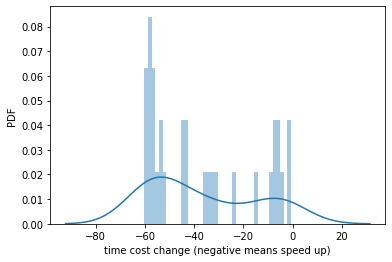

In [7]:
compare(d_back_before, d_back_after, 'backward')